## [Computational Social Science] Project 5: Natural Language Processing

### Team 4: Elleni Hailu, Lawrence Liu, and Ángel Mendiola Ross
### Due: February 26, 2020

In this project, we use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, we do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

We explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
#install spacy language detect capability, uncomment below if not yet installed 
#!pip install spacy-langdetect

In [2]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation

from spacy.lang.en.stop_words import STOP_WORDS
from spacy_langdetect import LanguageDetector #so we can add a feature to the dataframe indicating whether English text or not

import en_core_web_sm
nlp = en_core_web_sm.load()

#add language detection to spaCy pipeline
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#replicabilty
import random

#regex to help remove graphical emojis
import re 

In [3]:
random.seed(49764) #set seed for replicability w/ sample

congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(5000) 
#LL: note I picked 5000 arbitrarily for now; we'll want to come back to this and adjust up as we get code to work
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
410147,1.306020e+18,RepMcGovern,2020-09-15T20:12:30-04:00,America is the richest country in the world.\n...,Jim McGovern,Rep,3-Jan-97,11/20/1959,M,MA,2,Democrat,"1,090,893","1,995,196","1,921,290","1,188,314"
339336,1.141700e+18,RepDavids,2019-06-20T09:48:01-04:00,The Congressional Women’s Softball Game might ...,Sharice Davids,Rep,3-Jan-19,5/22/1980,F,KS,3,Democrat,"671,018","427,005","440,726","692,634"
663094,1.106270e+18,RonWyden,2019-03-14T15:08:59-04:00,I voted to block Trump's unconstitutional nati...,Ron Wyden,Sen,5-Feb-96,5/3/1949,M,OR,Senate,Democrat,"782,403","1,002,106","970,488","754,175"
813762,1.260970e+18,RepFletcher,2020-05-14T12:28:15-04:00,"Happening now, and again at 1PM. #HoustonToget...",Lizzie Fletcher,Rep,3-Jan-19,2/13/1975,F,TX,7,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
211392,1.145480e+18,RepDMP,2019-06-30T19:39:31-04:00,Listening to the voices of this beautiful choi...,Debbie Mucarsel-Powell,Rep,3-Jan-19,1/18/1971,F,FL,26,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"


In [4]:
congress_tweets.shape

(5000, 16)

## Preprocessing Text Data

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [5]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
#function to remove graphical emojis
#copied from: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python/50602709#50602709

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [7]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation) #should get rid of hashtags and @s
    
    punc_free = "".join([ch for ch in text if ch not in punc]) #turns text into a string object
    
    punc_free = punc_free.lower() #lower-case the words
    
    punc_free = punc_free.replace('rt', '') #delete rt
    
    punc_free = punc_free.replace('qt', '') #delete qt
    
    punc_free = punc_free.replace('amp', '') #delete ampersand
    
    punc_free = deEmojify(punc_free) #remove graphical emojis
    
    punc_free = " ".join(punc_free.split()) #removes all whitespace characters (space, line breaks, etc.)

    #punc_free = punc_free.replace('\n', '') #remove line breaks
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [8]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

410147    [america, richest, country, world, night, time...
339336    [congressional, women, softball, game, gone, w...
663094    [voted, block, trumps, unconstitutional, natio...
813762    [happening, 1, pm, houstontogether, houstonhea...
211392    [listening, voices, beautiful, choir, hopeful,...
                                ...                        
843108    [free, fair, elections, nation, representative...
227611    [white, house, opted, today, novel, defense, “...
133752    [proud, join, colleagues, house, senate, calli...
9804      [governorkayivey, truly, heabreaking, hurrican...
368764    [maines, fisheries, –, paicularly, lobster, in...
Name: tokens, Length: 5000, dtype: object

## Adding Feature Indicating the Tweet Language

Since some of the tweets are in non-English languages, we added a column to the dataframe that indicates the language of the tweet as identified by spaCy. 

In [9]:
#example of how it works and what is output
test_text = ['.', 'this is a test string']
for text in test_text:
    doc = nlp(text)
    print(doc._.language)

{'language': 'UNKNOWN', 'score': 0.0}
{'language': 'en', 'score': 0.9999989954029145}


In [10]:
#code adapted from: https://www.kaggle.com/shawamar/language-detection-using-spacy
#LL note 2/14/21: note that w/ 5000 tweets, this took me ~3 minutes to run

#create container for tweet languages and loop through text column of dataframe
tweets = congress_tweets['text']
languages_spacy = []

for text in tweets:
    doc = nlp(text)
    languages_spacy.append(list(doc._.language.values())[0])

#add column to df indicating language of tweet
congress_tweets['languages_spacy'] = languages_spacy

In [11]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,languages_spacy
410147,1.306020e+18,RepMcGovern,2020-09-15T20:12:30-04:00,America is the richest country in the world.\n...,Jim McGovern,Rep,3-Jan-97,11/20/1959,M,MA,2,Democrat,"1,090,893","1,995,196","1,921,290","1,188,314","[america, richest, country, world, night, time...",en
339336,1.141700e+18,RepDavids,2019-06-20T09:48:01-04:00,The Congressional Women’s Softball Game might ...,Sharice Davids,Rep,3-Jan-19,5/22/1980,F,KS,3,Democrat,"671,018","427,005","440,726","692,634","[congressional, women, softball, game, gone, w...",en
663094,1.106270e+18,RonWyden,2019-03-14T15:08:59-04:00,I voted to block Trump's unconstitutional nati...,Ron Wyden,Sen,5-Feb-96,5/3/1949,M,OR,Senate,Democrat,"782,403","1,002,106","970,488","754,175","[voted, block, trumps, unconstitutional, natio...",en
813762,1.260970e+18,RepFletcher,2020-05-14T12:28:15-04:00,"Happening now, and again at 1PM. #HoustonToget...",Lizzie Fletcher,Rep,3-Jan-19,2/13/1975,F,TX,7,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843","[happening, 1, pm, houstontogether, houstonhea...",en
211392,1.145480e+18,RepDMP,2019-06-30T19:39:31-04:00,Listening to the voices of this beautiful choi...,Debbie Mucarsel-Powell,Rep,3-Jan-19,1/18/1971,F,FL,26,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[listening, voices, beautiful, choir, hopeful,...",en


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

Before beginning our EDA, we wanted to get a feel for our data so we first plot a series of count plots.

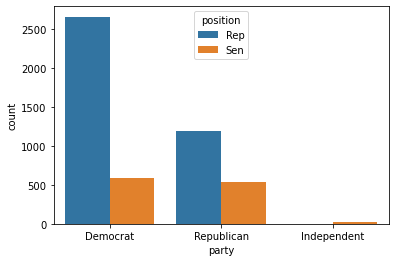

In [12]:
# looking at the number of tweets by Dem/Repub and by Senator/Representative
sns.countplot(x="party", hue = "position", data=congress_tweets);

The plot above shows that representatives tweet more than Senators. But this may be due to the fact that there are more representatives than senators. It also appears that among Representatives, Democrats tweet more than Republicans. But lets look at the underlying makeup of our data.

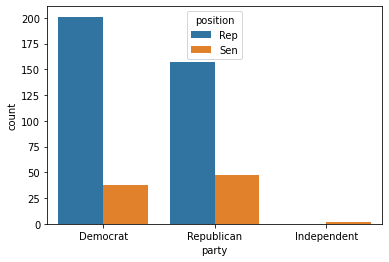

In [13]:
# looking at the number of tweets by Dem/Repub and by Senator/Representative
# plotting only unique rows
test = congress_tweets.drop_duplicates(subset = ["screen_name"])
sns.countplot(x="party", hue = "position", data=test);

In [14]:
# getting the numbers from the plots above
pd.crosstab(test.party, test.position)

position,Rep,Sen
party,,
Democrat,201,38
Independent,0,2
Republican,157,47


We see a similar breakdown looking only at breakdown of Senators and Representatives in our dataset. Comparing the results to the first plot suggests that Democratic Representatives do tweet more than Republican representatives. While there are clearly more Democratic representatives than Republicans (200 compared to 156), Democratic Representatives tweeted 2,537 times while Republican Representatives tweeted 1,272 times.

Before moving on, we want to check if these findings are driven in part by gender. We may expect, for example, that male members of Congress tweet more than female members.

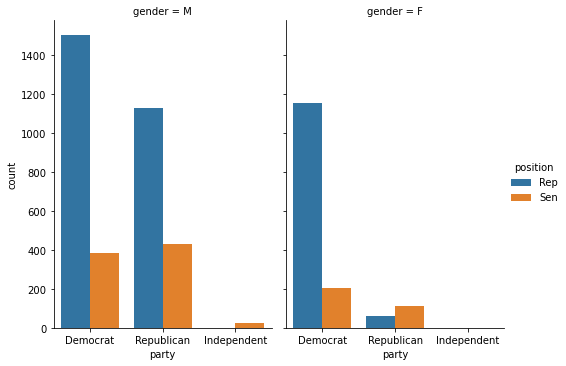

In [15]:
sns.catplot(x="party", hue = "position", col="gender",
            data=congress_tweets, kind="count",
            height=5, aspect=.7);

While Democratic Representatives still tweet more than Republicans, male Representatives in both parties tweet more than their female counterparts (but this is also likely influenced by the fact that there are more male representatives than female representatives).

### EDA 1

To get a better sense of common words, we first plot a word cloud of the tweets.

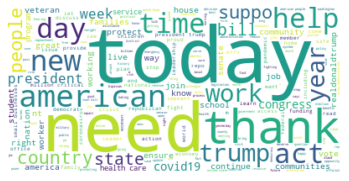

In [16]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Convert list of tokens back to string
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
# feed string to wordcloud
wordcloud = WordCloud(background_color = "white").generate(text)
# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Many of the largest words in the word cloud are fairly predictable: today, american, thank, need, and help.

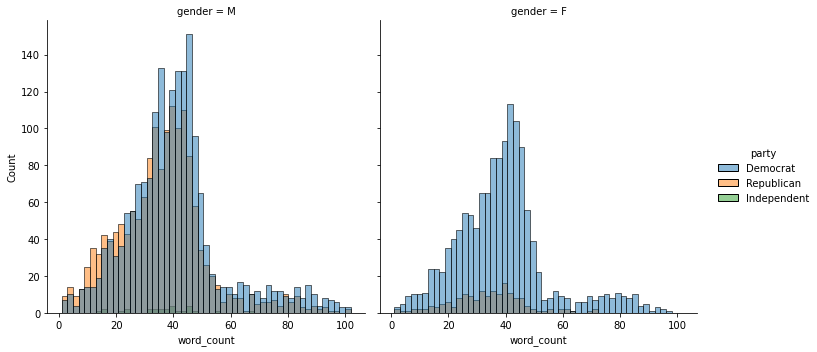

In [17]:
# adding length columns
congress_tweets['tweet_len'] = congress_tweets['text'].apply(len)
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))
sns.displot(congress_tweets, x="word_count", hue = "party", col = "gender")
plt.show()

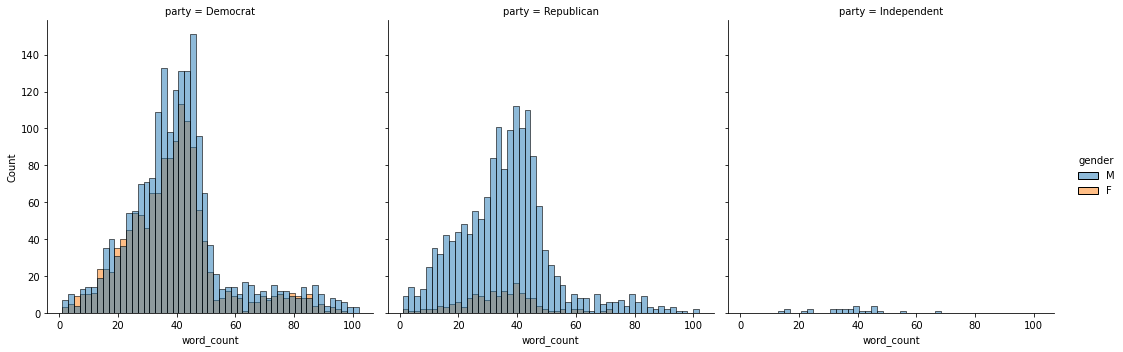

In [18]:
sns.displot(congress_tweets, x="word_count", hue = "gender", col = "party")
plt.show()

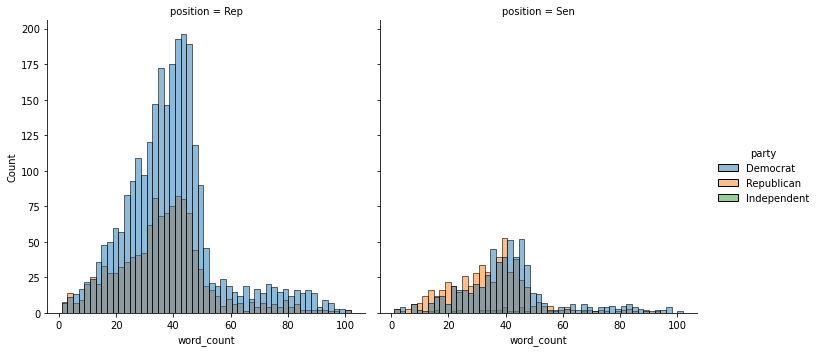

In [19]:
sns.displot(congress_tweets, x="word_count", hue = "party", col = "position")
plt.show()

### EDA 2

For our second EDA, we opted to try LDA.

In [20]:
# removing Independent representatives because it's only a few representatives but pretty distinct from Repub/Dem
no_indep = congress_tweets[congress_tweets.party != 'Independent']
X = no_indep['text']

tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

In [21]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [22]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [23]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
“ ” week act great president new health stop veterans today school care thank american human lower trump students house

Topic #1:
realdonaldtrump today act house thank — women work 911 day congress covid19 violence join vote way suppo right trump new

Topic #2:
trump president house today people need health americans time work american act senate care covid19 suppo congress democrats help workers

Topic #3:
bill ” “ act today economy right bipaisan m new people american help federal proud suppo nt health need americans

Topic #4:
covid19 need today de happy health work act help ️ join proud pandemic american bill trump house families crisis protect

Topic #5:
today people trump country day thank health women american covid19 congress care need time right act nation americans great president

Topic #6:
today thank help small covid19 community office businesses president time day state new health great students need “ business work



In [24]:
# assigning topic weights
topic_dist = lda.transform(tfidf_matrix)

topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(no_indep.reset_index())

grouped = df_w_topics.groupby('party')
for i in range(0, 7):
    print(grouped[i].mean().sort_values(ascending=False))

party
Republican    0.087668
Democrat      0.083854
Name: 0, dtype: float64
party
Republican    0.108622
Democrat      0.097396
Name: 1, dtype: float64
party
Democrat      0.308483
Republican    0.290741
Name: 2, dtype: float64
party
Republican    0.115503
Democrat      0.111194
Name: 3, dtype: float64
party
Democrat      0.141392
Republican    0.134305
Name: 4, dtype: float64
party
Democrat      0.133776
Republican    0.131163
Name: 5, dtype: float64
party
Republican    0.131997
Democrat      0.123903
Name: 6, dtype: float64


Topics 0 and 1 seem to have the most divergence--even though the differences are pretty small. We tried a range of topic sizes (e.g., 4 to 30) and these were the best we could get. Most differences were less than one percentage point.

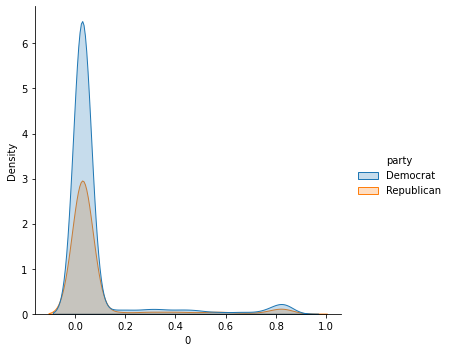

In [25]:
sns.displot(df_w_topics, x=df_w_topics[0], hue = "party", kind = 'kde', fill = 'true')
plt.show()

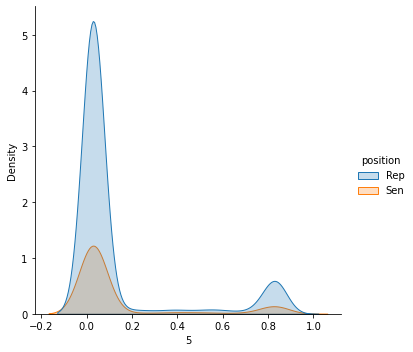

In [26]:
sns.displot(df_w_topics, x=df_w_topics[5], hue = "position", kind = 'kde', fill = 'true')
plt.show()

Ultimately, the topics do not distinguish well between Senators and Representatives or Republicans and Democrats.

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [27]:
# More conservative representative: Paul Gosar
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
pg_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Paul Gosar']

#congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
pg_tweets['polarity'] = pg_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
pg_tweets['subjectivity'] = pg_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# More liberal representative: Barbara Lee
bl_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Barbara Lee']
bl_tweets['polarity'] = bl_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
bl_tweets['subjectivity'] = bl_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# combining data frames
frames = [pg_tweets, bl_tweets]
polarity_df = pd.concat(frames)

<ipython-input-27-b3276d03daee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pg_tweets['polarity'] = pg_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-27-b3276d03daee>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pg_tweets['subjectivity'] = pg_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
<ipython-input-27-b3276d03daee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

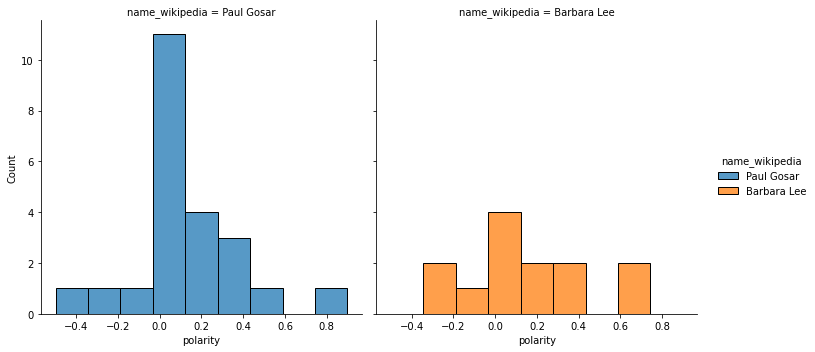

In [28]:
sns.displot(polarity_df, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

In [29]:
# checking most negative tweets for Barbara Lee
for tweet in bl_tweets.nsmallest(3, 'polarity')['text']:
    print(tweet + "\n")

Trump’s continuous assault on women’s constitutionally protected right to an abortion is dangerous and wrong. As PCC Co-Chair I’ll keep fighting to #ProtectX so that everyone can access comprehensive reproductive care. https://www.washingtonpost.com/health/2019/06/20/court-allows-new-trump-administration-abortion-gag-rule-go-into-effect/?utm_term=.351b7a119017

We must keep working for change and justice everyday. Don’t let the movement die. #BlackLivesMattters https://www.npr.org/sections/health-shots/2020/06/07/870251488/beyond-protests-5-more-ways-to-channel-anger-into-action-to-fight-racism

When more than 140 million people in the richest nation on earth are in or on the edge of poverty, it’s past time to take action. It's past time for Congress to take action to end the moral crisis of poverty once and for all. http://pbs.twimg.com/media/D9cb-ItXkAEUPMi.jpg https://video.twimg.com/amplify_video/1141411341170806784/vid/320x320/5g1c80F96z9sMXci.mp4?tag=13



In [30]:
# checking most negative tweets for Paul Gosar
for tweet in pg_tweets.nsmallest(3, 'polarity')['text']:
    print(tweet + "\n")

RT @westerncaucus Praying for her during this difficult time 🙏🏻 https://twitter.com/pagesix/status/1223068703505494016 QT @PageSix Nicky Hilton is fighting climate change by wearing vintage Chanel https://pagesix.com/2020/01/30/nicky-hilton-is-fighting-climate-change-by-wearing-vintage-chanel/?utm_campaign=SocialFlow&utm_medium=SocialFlow&utm_source=P6Twitter http://pbs.twimg.com/media/EPk2gQLWsAAU3FW.jpg

Arizona small businesses hurt by the Wuhan #coronavirus pandemic can apply for up to $2 million each in loans from the ⁦@SBAgov⁩ now that the agency has accepted the state’s disaster declaration request. #AZ04  https://www.bizjournals.com/phoenix/news/2020/03/19/2m-loans-available-to-arizona-small-businesses.html

RT @abc15 PD: Man cited for extreme DUI after crashing into a Phoenix Fire Department fire engine: https://www.abc15.com/news/region-phoenix-metro/pd-man-cited-for-extreme-dui-after-crashing-into-a-phoenix-fire-department????? #abc15 http://pbs.twimg.com/media/EhwYL9SU8AAk9

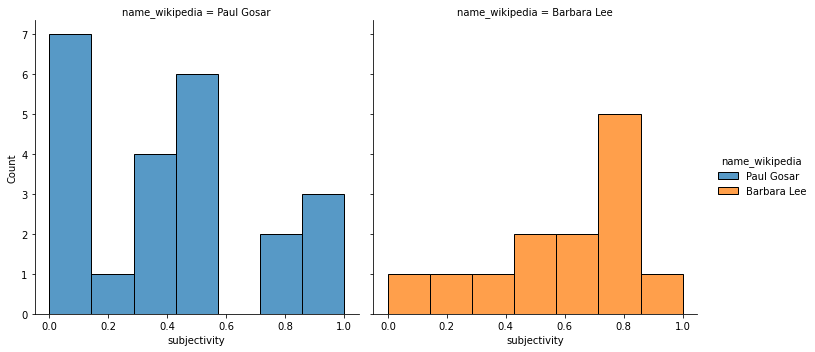

In [31]:
sns.displot(polarity_df, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

In [32]:
# checking most subjective tweet for Barbara Lee
for tweet in bl_tweets.nlargest(1, 'subjectivity')['text']:
    print(tweet + "\n")

Glad to be at the State of Cannabis Summit to talk about the important progress we’re making in Congress on cannabis reform, legalization, and restorative justice, especially for communities of color! #MarijuanaJustice http://pbs.twimg.com/media/EJiru6hXYAA5swd.jpg



In [33]:
# checking most subjective tweet for Paul Gosar
for tweet in pg_tweets.nlargest(1, 'subjectivity')['text']:
    print(tweet + "\n")

RT @westerncaucus Praying for her during this difficult time 🙏🏻 https://twitter.com/pagesix/status/1223068703505494016 QT @PageSix Nicky Hilton is fighting climate change by wearing vintage Chanel https://pagesix.com/2020/01/30/nicky-hilton-is-fighting-climate-change-by-wearing-vintage-chanel/?utm_campaign=SocialFlow&utm_medium=SocialFlow&utm_source=P6Twitter http://pbs.twimg.com/media/EPk2gQLWsAAU3FW.jpg



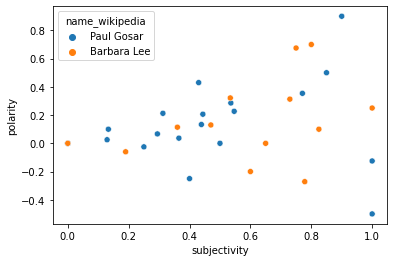

In [34]:
sns.scatterplot(x = polarity_df['subjectivity'], y = polarity_df['polarity'], hue = polarity_df['name_wikipedia'])

The scores for Representatives Paul Gosar (R) and Barbara Lee (D) do not match what we had originally thought. Given Trump's hold on the Republican Party and his outlandishly subjective and negative rhetoric, we thought that Rep. Gosar's tweets would be rated both more subjective and more negative than Rep. Lee's. But in fact, the opposite was true. Looking into what tweets ranked most negative, they are critique's of Trump's COVID response and the impact of COVID-19 on vulnerable communities. For subjectivity, Rep. Lee's tweet about healing from the past and addressing white supremacy ranks the most subjective. In comparison, Rep. Gosar's most subjective tweet is just "Thank you". Apparently the model ranks acknowleding and healing from white supremacy as extremeley subjective.

In [35]:
# now looking at subjectivity and polarity across all members
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

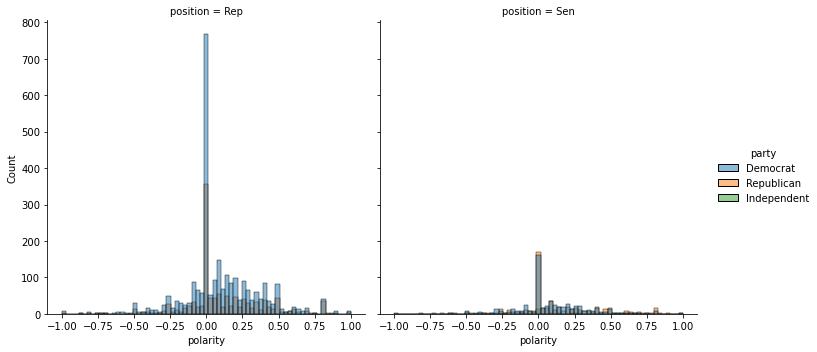

In [36]:
sns.displot(congress_tweets, x="polarity", hue = "party", col = "position")
plt.show()

In [37]:
# checking most negative tweets
for tweet in congress_tweets.nsmallest(3, 'polarity')['text']:
    print(tweet + "\n")

We must end police brutality in America. The families of #GeorgeFloyd and the other victims of these horrific crimes deserve justice. People need to be held accountable for their actions so this never happens again.

This is downright cruel. During Pride month &amp; on the anniversary of a horrific attack against the LGBTQ community, the Trump administration is jeopardizing lives. https://www.npr.org/sections/health-shots/2020/06/12/868073068/transgender-health-protections-reversed-by-trump-administration?utm_campaign=storyshare&utm_source=facebook.com&utm_medium=social&fbclid=IwAR3TnYfcebluSEm4mWsh0eLxg90Gs9LwUNpGW-u3heHD1JRN4M7J3md37ek

I just met w/ a group visiting D.C. for the National Pancreatic Cancer Advocacy Day. I'm always honored to hear their stories &amp; how this disease has impacted them &amp; their families. We discussed how Congress can help fight back against this terrible disease. #MomentsMatter http://pbs.twimg.com/media/D962f8-WwAEfmRr.jpg



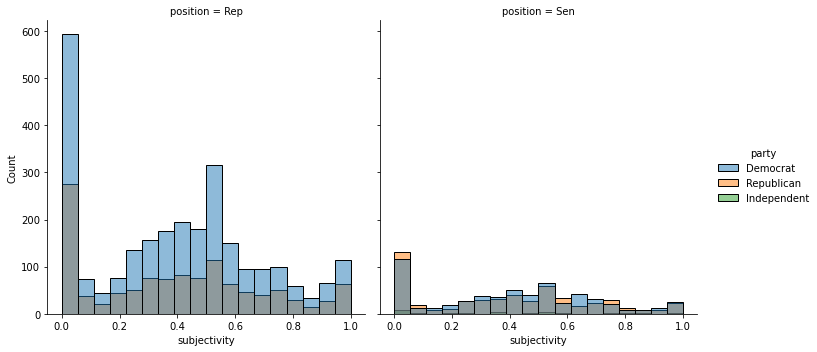

In [38]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "position")
plt.show()

The trends by party and chamber on both polarity and subjectivity look fairly similar.

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [ ]:
# Engineered Features
...

### Bag-of-words or Tf-idf

In [ ]:
# Frequency Based featurization
...

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [ ]:
# embedding based featurization
...

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**